# Train Fasttext language model using Gensim
We use the *6000 Indian Food Recipes* recipe data from here: 
https://www.kaggle.com/kanishk307/6000-indian-food-recipes-dataset

In [2]:
import pandas as pd
import numpy as np
import collections
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short
from textblob import TextBlob, Word

import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [3]:
import os
fc=0
for el in os.listdir("."):
    fc+=1
    print(" - ",el)
print("found",fc,"files!")

 -  .ipynb_checkpoints
 -  1_trainRecipeEmbeddings.ipynb
 -  2_indexRecipeData.ipynb
 -  2_trainEmbeddings.ipynb
 -  data
 -  models
 -  processed
 -  recipeEmbeddingsBasedSearch.ipynb
found 8 files!


In [4]:
raw = pd.read_csv(r"C:\Users\arnab\Documents\workspace\food\whatscooking\downloads\IndianFoodDatasetCSV.csv")
df = raw.copy()
df.head()

,Srno,RecipeName,TranslatedRecipeName,Ingredients,TranslatedIngredients,PrepTimeInMins,CookTimeInMins,TotalTimeInMins,Servings,Cuisine,Course,Diet,Instructions,TranslatedInstructions,URL
0,1,Masala Karela Recipe,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...","6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",15,30,45,6,Indian,Side Dish,Diabetic Friendly,"To begin making the Masala Karela Recipe,de-se...","To begin making the Masala Karela Recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...
1,2,टमाटर पुलियोगरे रेसिपी - Spicy Tomato Rice (Re...,Spicy Tomato Rice (Recipe),"2-1/2 कप चावल - पका ले,3 टमाटर,3 छोटा चमच्च बी...","2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",5,10,15,3,South Indian Recipes,Main Course,Vegetarian,टमाटर पुलियोगरे बनाने के लिए सबसे पहले टमाटर क...,"To make tomato puliogere, first cut the tomato...",http://www.archanaskitchen.com/spicy-tomato-ri...
2,3,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...","1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",20,30,50,4,South Indian Recipes,South Indian Breakfast,High Protein Vegetarian,"To begin making the Ragi Vermicelli Recipe, fi...","To begin making the Ragi Vermicelli Recipe, fi...",http://www.archanaskitchen.com/ragi-vermicelli...
3,4,Gongura Chicken Curry Recipe - Andhra Style Go...,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...","500 grams Chicken,2 Onion - chopped,1 Tomato -...",15,30,45,4,Andhra,Lunch,Non Vegeterian,To begin making Gongura Chicken Curry Recipe f...,To begin making Gongura Chicken Curry Recipe f...,http://www.archanaskitchen.com/gongura-chicken...
4,5,आंध्रा स्टाइल आलम पचड़ी रेसिपी - Adrak Chutney ...,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 बड़ा चमच्च चना दाल,1 बड़ा चमच्च सफ़ेद उरद दाल,2...","1 tablespoon chana dal, 1 tablespoon white ura...",10,20,30,4,Andhra,South Indian Breakfast,Vegetarian,आंध्रा स्टाइल आलम पचड़ी बनाने के लिए सबसे पहले ...,"To make Andhra Style Alam Pachadi, first heat ...",https://www.archanaskitchen.com/andhra-style-a...


# Basic insights and data processing

In [5]:
#we keep the Translated versions of Ingredients and Instructions (already pre-processed data)
columns_to_drop = ['RecipeName', 'Ingredients', 'PrepTimeInMins' , 'CookTimeInMins',
                   'TotalTimeInMins', 'Instructions', 'Servings', 'Srno']
df_indianRecipes = df.drop(columns = columns_to_drop).dropna()
df_indianRecipes.head()

,TranslatedRecipeName,TranslatedIngredients,Cuisine,Course,Diet,TranslatedInstructions,URL
0,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",Indian,Side Dish,Diabetic Friendly,"To begin making the Masala Karela Recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",South Indian Recipes,Main Course,Vegetarian,"To make tomato puliogere, first cut the tomato...",http://www.archanaskitchen.com/spicy-tomato-ri...
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",South Indian Recipes,South Indian Breakfast,High Protein Vegetarian,"To begin making the Ragi Vermicelli Recipe, fi...",http://www.archanaskitchen.com/ragi-vermicelli...
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...",Andhra,Lunch,Non Vegeterian,To begin making Gongura Chicken Curry Recipe f...,http://www.archanaskitchen.com/gongura-chicken...
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 tablespoon chana dal, 1 tablespoon white ura...",Andhra,South Indian Breakfast,Vegetarian,"To make Andhra Style Alam Pachadi, first heat ...",https://www.archanaskitchen.com/andhra-style-a...


<AxesSubplot:ylabel='word'>

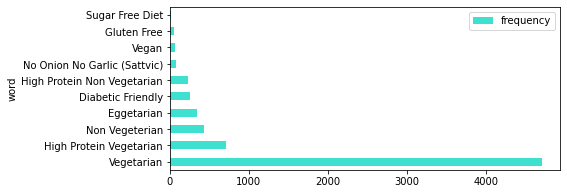

In [6]:
#we'll use the embeddings for classification later
counts_ingr = collections.Counter(df_indianRecipes['Diet'])
most_common = counts_ingr.most_common()
mc = pd.DataFrame(most_common, columns=['word', 'frequency'])
mc.plot(kind='barh', x='word', color='turquoise',figsize=(7,3))

<AxesSubplot:ylabel='word'>

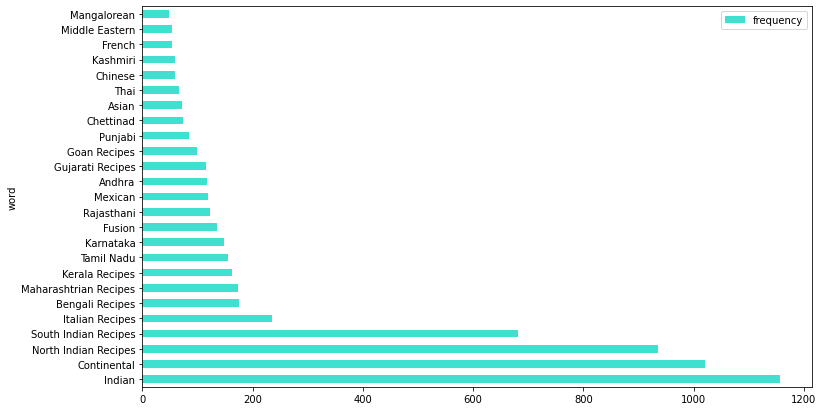

In [7]:
#histogram on cuisines
#df_indianRecipes['Cuisine'].hist(xrot=90,figsize=(15,10))
counts_ingr = collections.Counter(df_indianRecipes['Cuisine'])
most_common = counts_ingr.most_common(25)
mc = pd.DataFrame(most_common, columns=['word', 'frequency'])

#print("\nMost common:\n", mc)
mc.plot(kind='barh', x='word', align='center', color='turquoise',figsize=(12,7))

In [8]:
#some more processing, dropping columns in hindi, copied from a notebook in kaggle
#df_indianRecipes = df_indianRecipes['TranslatedIngredients']
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
#create boolean mask
mask = df_indianRecipes['TranslatedIngredients'].apply(isEnglish)
df_indianRecipes = df_indianRecipes[mask].dropna()

print("Shape of recipe data:",df_indianRecipes.shape)

Shape of recipe data: (6173, 7)


In [9]:
#more preprocessing on the text fields
df_indianRecipes['TranslatedIngredients'] = df_indianRecipes['TranslatedIngredients'].apply(lambda x: x.lower())

total_ingredients = []
all_receipes_ingredients =  []
for i in range(len(df_indianRecipes)):
    all_ingredients = list()
    #split each recipe into different ingredients
    try:
        ingred = df_indianRecipes.loc[i, "TranslatedIngredients"][1:-1]
    except:
        continue;
      
    for ing in (ingred.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        
        #convert plurals to singular e.g. tomatoes --> tomato
        ing = (" ".join(TextBlob(ing).words.singularize()))
        if len(ing)>0:
            all_ingredients.append(ing)
            total_ingredients.append(ing)
    all_receipes_ingredients.append(all_ingredients)
counts_ingr = collections.Counter(total_ingredients)

---- Most Common Ingredients ----
[('salt', 4315), ('turmeric powder haldi', 1681), ('chilli powder', 1595), ('jeera', 1131), ('sunflower oil', 1030), ('chilly', 842), ('sugar', 779), ('curry leaf', 775), ('asafoetida hing', 712), ('garam masala powder', 699), ('s', 655), ('coriander powder dhanium', 648), ('black pepper powder', 627), ('lemon juice', 612), ('water', 572), ('ghee', 559), ('cumin powder jeera', 535), ('extra virgin olive oil', 503), ('clove garlic', 466), ('milk', 450), ('cinnamon stick dalchini', 440), ('flmy maida', 428), ('wheat flmy', 402), ('curd dahi yogurt', 386), ('clove laung', 369)]


---- Least Common Ingredients ----
[('cumin powder jeera cumin powder', 1), ('coconut milk consistency', 1), ('coconut oil regular oil', 1), ('turmeric powder haldi to add boiling veggie', 1), ('tamarind paste little', 1), ('gm parwal peel chop straight', 1), ('tsp watermelon', 1), ('egg egg', 1), ('sunflower oil ghee frying parath', 1), ('rose petal garnishing optional', 1)]
typ

<AxesSubplot:ylabel='word'>

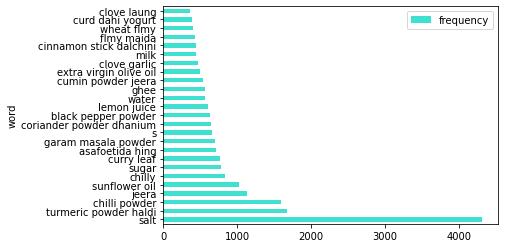

In [10]:
#find the most common ingredients used across all recipes
print ("---- Most Common Ingredients ----")
print (counts_ingr.most_common(25))

print ("\n")
#find the most common ingredients used across all recipes
print ("---- Least Common Ingredients ----")
print (counts_ingr.most_common()[-10:])
print("type counts ingr",type(counts_ingr))

most_common = counts_ingr.most_common(25)
mc = pd.DataFrame(most_common, columns=['word', 'frequency'])

#print("\nMost common:\n", mc)
mc.plot(kind='barh', x='word', align='center', color='turquoise')

In [11]:
#convert to lower case
df_indianRecipes['TranslatedInstructions'] = df_indianRecipes['TranslatedInstructions'].apply(lambda x: x.lower())

#total_ingredients = []
all_instructions =  []

#len(df_indianRecipes)
for i in range(len(df_indianRecipes)):
    #split each recipe into different ingredients
    try:
        instrs = df_indianRecipes.loc[i, "TranslatedInstructions"][1:-1]
        #print("instrs\n",instrs)
    except:
        continue;      
    for instr in (instrs.split('.')):
        instr = remove_stopwords(instr)
        instr = strip_numeric(instr)
        #instr = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|cup','',ing).strip()
        instr = strip_short(instr,2)
        instr = strip_multiple_whitespaces(instr)
        instr = strip_punctuation(instr)
        instr = strip_non_alphanum(instr)
        #convert plurals to singular e.g. tomatoes --> tomato
        instr = (" ".join(TextBlob(instr).words.singularize()))
        if len(instr)>0:
            all_instructions.append(instr)

print("len",len(all_instructions))

#formatting the column in a way the gensim takes it
all_instructions_splitted = [sentx.split() for sentx in all_instructions]
df_indianRecipes.to_pickle("processed/df_indianRecipes.pkl")

len 78073


In [12]:
#record the number of ingredients for each recipe, 
#add cleaned instructions for training recipe embeddings
#add cleaned ingredients back to original dataframe
df_indianRecipes['clean_ingredients'] = pd.Series(all_receipes_ingredients)
df_indianRecipes = df_indianRecipes.dropna()
df_indianRecipes['ingredient_count'] =  df_indianRecipes.apply(lambda row: len(row['clean_ingredients']), axis = 1)
df_indianRecipes['clean_instructions'] = df_indianRecipes['TranslatedInstructions'].apply(lambda x: x.lower())
df_indianRecipes['clean_instructions'].head()

0    to begin making the masala karela recipe,de-se...
1    to make tomato puliogere, first cut the tomato...
2    to begin making the ragi vermicelli recipe, fi...
3    to begin making gongura chicken curry recipe f...
4    to make andhra style alam pachadi, first heat ...
Name: clean_instructions, dtype: object

In [13]:
df_indianRecipes.to_pickle("processed/df_indianRecipes.pkl")

In [14]:
#function to process the column 'recipe' to the format of list-of-lists
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_non_alphanum, strip_multiple_whitespaces, strip_short

def process_recipe(recipe):
    recipeProcessed = []
    for ing in (recipe.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|recipe|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        if ing:
            #print("ing",ing)
            recipeProcessed.append(ing)
    #print("recipeProcessed",len(recipeProcessed),recipeProcessed)
    return [oneInstr.split() for oneInstr in recipeProcessed]

process_recipe(df_indianRecipes['clean_instructions'][10])

[['beans'],
 ['step',
  'cook',
  'them',
  'like',
  'pressure',
  'cooker',
  'method',
  'cook',
  'beans',
  'place',
  'beans',
  'pressure'],
 ['place', 'weight'],
 ['cover', 'pan', 'cook', 'water', 'heat', 'whistles'],
 ['ium',
  'heat',
  'add',
  'onions',
  'garlic',
  'light',
  'sauté',
  'onions',
  'tender',
  'add',
  'tomatoes'],
 ['tomatoes', 'cover', 'pan'],
 ['beans', 'coriander', 'leaves', 'serve', 'toast'],
 ['potato', 'cakes']]

In [15]:
#adding clean instructions
df_indianRecipes['clean_instructions'] = df_indianRecipes['clean_instructions'].apply(lambda x:process_recipe(x))
print(df_indianRecipes['clean_instructions'][1])

[['tomato', 'puliogere'], ['cut', 'tomatoes', 'mixer', 'grinder', 'puree', 'it', 'heat', 'oil', 'pan', 'oil', 'hot'], ['add', 'chana', 'dal'], ['urad', 'dal'], ['cashew', 'let', 'cook', 'seconds', 'seconds'], ['chillies'], ['chillies', 'curry', 'leaves', 'seconds'], ['add', 'tomato', 'puree', 'mix', 'add', 'bc', 'belle', 'bhat', 'powder'], ['salt', 'mix', 'it', 'allow', 'cook', 'minutes', 'turn', 'gas', 'bowl'], ['rice', 'mix', 'it', 'serve', 'hot', 'serve', 'tomato', 'puliogre', 'tomato', 'cucumber', 'raita', 'papad', 'dinner']]


In [16]:
sentenced_Instructions = df_indianRecipes['clean_instructions']
#all_Sentences is the list of sentences in a format that gensim uses
#list of sentences, where every sentence is a list of words
all_Sentences = []
for sentence in sentenced_Instructions:
    all_Sentences.extend(sentence)
print(len(sentenced_Instructions),"recipes!")
print(len(all_Sentences),"sentences!")
all_Sentences

5020 recipes!
49899 sentences!


[['begin', 'making', 'masala', 'karela'],
 ['karela',
  'slice',
  'remove',
  'skin',
  'skin',
  'nutrients',
  'add',
  'karela',
  'pressure',
  'cooker',
  'water'],
 ['add',
  'onions',
  'saute',
  'till',
  'turns',
  'golden',
  'brown',
  'color',
  'add',
  'karela'],
 ['chilli', 'powder'],
 ['amchur', 'powder'],
 ['tomato', 'puliogere'],
 ['cut',
  'tomatoes',
  'mixer',
  'grinder',
  'puree',
  'it',
  'heat',
  'oil',
  'pan',
  'oil',
  'hot'],
 ['add', 'chana', 'dal'],
 ['urad', 'dal'],
 ['cashew', 'let', 'cook', 'seconds', 'seconds'],
 ['chillies'],
 ['chillies', 'curry', 'leaves', 'seconds'],
 ['add', 'tomato', 'puree', 'mix', 'add', 'bc', 'belle', 'bhat', 'powder'],
 ['salt', 'mix', 'it', 'allow', 'cook', 'minutes', 'turn', 'gas', 'bowl'],
 ['rice',
  'mix',
  'it',
  'serve',
  'hot',
  'serve',
  'tomato',
  'puliogre',
  'tomato',
  'cucumber',
  'raita',
  'papad',
  'dinner'],
 ['begin', 'making', 'ragi', 'vermicelli'],
 ['firm',
  'keep',
  'aside',
  'aside',

# recipe embeddings using gensim

In [17]:
#training fastText model on recipe
from gensim.models import FastText
from gensim.test.utils import datapath
from gensim.utils import tokenize
from gensim import utils

model_indianfood_fasttext = FastText(size=100, window=5, min_count=5, workers=4,sg=1)
model_indianfood_fasttext.build_vocab(sentences=all_Sentences)
total_examples = model_indianfood_fasttext.corpus_count
print("training model!")
model_indianfood_fasttext.train(sentences=all_Sentences, total_examples=total_examples, epochs=5)
print("saving model!")
model_indianfood_fasttext.save("models/model_indianfood_fasttext.model")

training model!
saving model!


In [18]:
#model_indianfood_fasttext.save("models/model_indianfood_fasttext.model")
total_words1 = model_indianfood_fasttext.corpus_total_words
print(total_words1,"words in Recipe based model Corpus!")

model_indianfood_fasttext.wv.most_similar("daal sabji")

327995 words in Recipe based model Corpus!


[('sukha', 0.9495968222618103),
 ('sukhe', 0.9443870186805725),
 ('sabji', 0.9418803453445435),
 ('vagharela', 0.9411600232124329),
 ('phalguni', 0.938843309879303),
 ('khichia', 0.9387450814247131),
 ('khooba', 0.9372038245201111),
 ('rabodi', 0.9343590140342712),
 ('kanghou', 0.9335325956344604),
 ('sukhi', 0.9331086277961731)]

In [19]:
model_indianfood_fasttext.wv.most_similar("paneer")

[('seer', 0.8310918807983398),
 ('sheer', 0.8263018727302551),
 ('neer', 0.8107001185417175),
 ('bhurji', 0.7945016622543335),
 ('pani', 0.7879313826560974),
 ('pao', 0.7869946956634521),
 ('kulcha', 0.7759062647819519),
 ('macher', 0.7755663394927979),
 ('beer', 0.7722712755203247),
 ('tandoori', 0.7717341780662537)]

In [20]:
model_indianfood_fasttext.wv.most_similar("tandoori")

[('tikka', 0.9459533095359802),
 ('hari', 0.9128848314285278),
 ('kulcha', 0.906612753868103),
 ('bhurji', 0.9024192690849304),
 ('shikampuri', 0.8992996215820312),
 ('katori', 0.8986305594444275),
 ('kulchas', 0.893599271774292),
 ('achari', 0.8933065533638),
 ('shawarma', 0.8896741271018982),
 ('haleem', 0.8863043189048767)]

In [21]:
#defined functions to get to embeddings for recipes
def getSentenceEmbedding(sentence):
    countFound = 0
    embeddingList = []
    for wordx in sentence:
        try:
            vector1 = model_indianfood_fasttext.wv[wordx]
            #print("word",wordx, vector1[:3])
            embeddingList.append(vector1)
            countFound+=1
        except:
            continue;
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, countFound)  

def getRecipeEmbedding(instruction):
    embeddingList = []
    for sentence in instruction:
        embeddingList.append(getSentenceEmbedding(sentence))
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, len(instruction))  

In [ ]:
df_indianRecipes['recipe_embedding_fasttext'] =  df_indianRecipes.apply(lambda row: getRecipeEmbedding(row['clean_instructions']), axis = 1)

In [23]:
#checking out the new column
df_indianRecipes.to_pickle('processed/df_indianRecipes.pkl')
df_indianRecipes.head()

,TranslatedRecipeName,TranslatedIngredients,Cuisine,Course,Diet,TranslatedInstructions,URL,clean_ingredients,ingredient_count,clean_instructions,recipe_embedding_fasttext
0,Masala Karela Recipe,"6 karela (bitter gourd/ pavakkai) - deseeded,s...",Indian,Side Dish,Diabetic Friendly,"to begin making the masala karela recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...,"[salt, gram flmy besan, turmeric powder haldi,...",8,"[[begin, making, masala, karela], [karela, sli...","[-0.016737932, 0.35984662, -0.24503584, -0.063..."
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",South Indian Recipes,Main Course,Vegetarian,"to make tomato puliogere, first cut the tomato...",http://www.archanaskitchen.com/spicy-tomato-ri...,"[tomato, bc belle bhat powder, salt, chickpea ...",10,"[[tomato, puliogere], [cut, tomatoes, mixer, g...","[0.034362823, 0.29279393, -0.15771821, -0.1977..."
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups rice vermicelli noodles (thin),1 on...",South Indian Recipes,South Indian Breakfast,High Protein Vegetarian,"to begin making the ragi vermicelli recipe, fi...",http://www.archanaskitchen.com/ragi-vermicelli...,"[rice vermicelli noodle thin, pea matar, chill...",9,"[[begin, making, ragi, vermicelli], [firm, kee...","[0.025006209, 0.17075203, -0.1810968, -0.09942..."
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams chicken,2 onion - chopped,1 tomato -...",Andhra,Lunch,Non Vegeterian,to begin making gongura chicken curry recipe f...,http://www.archanaskitchen.com/gongura-chicken...,"[gram chicken, chilly slit, turmeric powder ha...",12,"[[ients, aside, in, small, pan], [ium, heat], ...","[0.0039616567, 0.19029821, -0.08325197, -0.147..."
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 tablespoon chana dal, 1 tablespoon white ura...",Andhra,South Indian Breakfast,Vegetarian,"to make andhra style alam pachadi, first heat ...",https://www.archanaskitchen.com/andhra-style-a...,"[chana dal, white urad dal, chilly, es ginger ...",11,"[[andhra, style, alam, pachadi], [chillies], [...","[0.054038156, 0.27010298, -0.04160401, -0.1178..."


In [24]:
#finding similar food-items using trained embeddings only

from numpy import dot
from numpy.linalg import norm

def find_Similar_dish(xx,embeddingToUse):
    #recipe_embedding_fasttext

    a = df_indianRecipes.loc[xx, embeddingToUse]
    orn = df_indianRecipes.loc[xx, "TranslatedRecipeName"]
    #print(orn,"\nGetting most similar dishes based on",embeddingToUse)
    dishtances = {}
    for i in range(len(df_indianRecipes)):
        if i==xx:
            continue;
        try:
            dn = df_indianRecipes.loc[i, "TranslatedRecipeName"]
            b = df_indianRecipes.loc[i, embeddingToUse]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            if cos_sim not in dishtances.values():
                dishtances[i] = cos_sim
        except:
            continue;
            
    dishtances_2 = {k: v for k, v in sorted(dishtances.items(), key=lambda item: item[1], reverse = True)}
    mostSimilarDishes = []
    countSim = 0
    for el in dishtances_2.keys():
        mostSimilarDishes.append(el)
        countSim+=1
        if countSim==10:
            break;
    return mostSimilarDishes

def list_Similar_dishes(xx, embeddingToUse):
    dn = df_indianRecipes.loc[xx, "TranslatedRecipeName"]
    additionalColumns = ['Cuisine','Course','Diet']
    similarList1 = find_Similar_dish(xx,embeddingToUse)
    simResults1 = []

    allSuggestedDishNames = []
    print("got all similar dishes!")
    for simIndex in similarList1:
        tempRes = []
        dName = df_indianRecipes.loc[simIndex, "TranslatedRecipeName"]
        dishName = " ".join([w for w in dName.split() if w.lower()!='recipe'])
        tempRes.append(dishName)
        dishNameShort = " ".join(dishName.split()[-2:])
        allSuggestedDishNames.append(dishNameShort)
        for col in additionalColumns:
            tempRes.append(df_indianRecipes.loc[simIndex, col])
        simResults1.append(tempRes)
    
    additionalColumns.insert(0,"Dish")
    print(dn)
    return(pd.DataFrame(simResults1, columns = additionalColumns),allSuggestedDishNames)

In [25]:
dishNumber = 311
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Kashmiri Style Chicken Pulao Recipe


,Dish,Cuisine,Course,Diet
0,Veg Makhanwala - North Indian Mixed Vegetables...,North Indian Recipes,Lunch,Vegetarian
1,Bengali Doi Maach (Fish In Yogurt Curry),Bengali Recipes,Lunch,Non Vegeterian
2,Bhindi Masala Gravy - Ladies Finger In Tomato ...,North Indian Recipes,Side Dish,Vegetarian
3,Andhra Style Chicken Fry,Andhra,Appetizer,High Protein Non Vegetarian
4,Delicious Methi Chicken Curry - Murgh Methi Curry,North Indian Recipes,Dinner,Non Vegeterian
5,Chettinad Muttai Masala - Chettinad Style Egg ...,Chettinad,Lunch,Eggetarian
6,Thalapakattu Chicken Biryani,Tamil Nadu,Main Course,Non Vegeterian
7,Lugai Gosht - Mutton In Spicy Tomato Onion Gravy,North Indian Recipes,Dinner,Non Vegeterian
8,Punjabi Style Egg Curry,Punjabi,Lunch,Eggetarian
9,Chettinad Thakkali Sadam (Chettinad Style Toma...,Chettinad,Lunch,Gluten Free


In [26]:
dishNumber = 567
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Homemade Easy Gulab Jamun Recipe - Delicious & Tasty


,Dish,Cuisine,Course,Diet
0,Malpua with Rabri (A Spiced Indian Pancake wit...,Indian,Dessert,Vegetarian
1,"Ragi, Wheat & Oat Waffles With Maple Syrup",Continental,World Breakfast,Eggetarian
2,Kaju Pista Roll - Cashew Nut Pistachio Fudge,North Indian Recipes,Dessert,Vegetarian
3,Basbousa - Middle Eastern Semolina Cake,Middle Eastern,Snack,Vegetarian
4,Homemade Whole Wheat Pav / Ladi Pav,Goan Recipes,Side Dish,Vegetarian
5,Eggless Chocolate Chip And Honey Cookies,Continental,Snack,Vegetarian
6,Eggless Fudgy Chocolate Chunk Brownie,Continental,Dessert,Vegetarian
7,Chiroti - Delicious Crispy Layered Sweet Puri,Indian,Dessert,Vegetarian
8,Karachi Biscuits,Indian,Snack,Vegetarian
9,Strawberry Brownie Bars,Continental,Dessert,Eggetarian
